In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer
from fastai.vision.learner import _add_norm

In [2]:
path = untar_data(URLs.PETS)
pat = r'/([^/]+)_\d+.*'
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2),
                 get_y=RegexLabeller(pat = pat),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = pets.dataloaders(path/'images', bs=bs)

In [3]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [4]:
# def cnn_learner(dls, arch, loss_func=None, pretrained=True,
#                cut=None, splitter=None, y_range=None, config=None,
#                n_out=None, normalize=True, **kwargs):
#     "Build a convnet style learner from `dls` and `arch`"
#     if config is None: config={}
#     meta = model_meta.get(arch, _default_meta)
#     if n_out is None: n_out = get_c(dls)
#     assert n_out,  "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
#     if normalize: _add_norm(dls, meta, pretrained)
#     if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
#     model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
#     learn=Learner(dls, model, loss_func, splitter=ifnone(splitter, meta['split'], **kwargs))
#     if pretrained: learn.freeze()
#     return learn

In [5]:
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3,
                     init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model  = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [6]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [7]:
def tst_param(val, grad=None):
    "Create a tensor with `val` and a gradient of `grad` for testing"
    res = tensor([val]).float()
    res.grad = tensor([val/10 if grad is None else grad]).float()
    return res

params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = Lamb(params, lr=0.1)

In [8]:
#export
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from fastai.callback.fp16 import ModelToHalf
from fastai.callback.hook import hook_output

#export
class TensorBoardBaseCallback(Callback):
    "Base class for tensorboard callbacks"
    def __init__(self):
        self.run_projector = False
        
    def after_pred(self):
        if self.run_projector: self.feat = _add_projector_features(self.learn, self.h, self.feat)
    
    def after_validate(self):
        if not self.run_projector: return
        self.run_projector = False
        self._remove()
        _write_projector_embedding(self.learn, self.writer, self.feat)
            
    def after_fit(self): 
        if self.run: self.writer.close()
        
    def _setup_projector(self):
        self.run_projector = True
        self.h = hook_output(self.learn.model[1][1] if not self.layer else self.layer)
        self.feat = {}
        
    def _setup_writer(self):
        self.writer = SummaryWriter(log_dir=self.log_dir)
    
    def _remove(self):
        if getattr(self, 'h', None): self.h.remove()

    def __del__(self): self._remove()

#export
class TensorBoardCallback(TensorBoardBaseCallback):
    "Saves model topology, losses & metrics for tensorboard and tensorboard projector during training"
    def __init__(self, log_dir=None, trace_model=True, log_preds=True, n_preds=9, projector=False, layer=None):
        super().__init__()
        store_attr()

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds") and rank_distrib()==0
        if not self.run: return
        self._setup_writer()
        if self.trace_model:
            if hasattr(self.learn, 'mixed_precision'):
                raise Exception("Can't trace model in mixed precision, pass `trace_model=False` or don't use FP16.")
            b = self.dls.one_batch()
            self.learn._split(b)
            self.writer.add_graph(self.model, *self.xb)

    def after_batch(self):
        self.writer.add_scalar('train_loss', self.smooth_loss, self.train_iter)
        for i,h in enumerate(self.opt.hypers):
            for k,v in h.items(): self.writer.add_scalar(f'{k}_{i}', v, self.train_iter)

    def after_epoch(self):
        for n,v in zip(self.recorder.metric_names[2:-1], self.recorder.log[2:-1]):
            self.writer.add_scalar(n, v, self.train_iter)
        if self.log_preds:
            b = self.dls.valid.one_batch()
            self.learn.one_batch(0, b)
            preds = getattr(self.loss_func, 'activation', noop)(self.pred)
            out = getattr(self.loss_func, 'decodes', noop)(preds)
            x,y,its,outs = self.dls.valid.show_results(b, out, show=False, max_n=self.n_preds)
            tensorboard_log(x, y, its, outs, self.writer, self.train_iter)
            
    def before_validate(self):
        if self.projector: self._setup_projector()
            
#export
class TensorBoardProjectorCallback(TensorBoardBaseCallback):
    "Extracts and exports image featuers for tensorboard projector during inference"
    def __init__(self, log_dir=None, layer=None):
        super().__init__()
        store_attr()
    
    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and hasattr(self, "gather_preds") and rank_distrib()==0
        if not self.run: return
        self._setup_writer()

    def before_validate(self):
        self._setup_projector()
        
#export
def _write_projector_embedding(learn, writer, feat):
    lbls = [learn.dl.vocab[l] for l in feat['lbl']] if getattr(learn.dl, 'vocab', None) else None     
    vecs = feat['vec'].squeeze()
    writer.add_embedding(vecs, metadata=lbls, label_img=feat['img'], global_step=learn.train_iter)
    
    
#export
def _add_projector_features(learn, hook, feat):
    img = _normalize_for_projector(learn.x)
    first_epoch = True if learn.iter == 0 else False
    feat['vec'] = hook.stored if first_epoch else torch.cat((feat['vec'], hook.stored),0)
    feat['img'] = img           if first_epoch else torch.cat((feat['img'], img),0)
    if getattr(learn.dl, 'vocab', None):
        feat['lbl'] = learn.y if first_epoch else torch.cat((feat['lbl'], learn.y),0)
    return feat

#export
def _get_embeddings(model, layer):
    layer = model[0].encoder if layer == None else layer
    return layer.weight

#export
@typedispatch
def _normalize_for_projector(x:TensorImage):
    # normalize tensor to be between 0-1
    img = x.clone()
    sz = img.shape
    img = img.view(x.size(0), -1)
    img -= img.min(1, keepdim=True)[0]
    img /= img.max(1, keepdim=True)[0]
    img = img.view(*sz)
    return img

# export
from fastai.text.all import LMLearner, TextLearner

#export
def projector_word_embeddings(learn=None, layer=None, vocab=None, limit=-1, start=0, log_dir=None):
    "Extracts and exports word embeddings from language models embedding layers"
    if not layer:
        if   isinstance(learn, LMLearner):   layer = learn.model[0].encoder
        elif isinstance(learn, TextLearner): layer = learn.model[0].module.encoder
    emb = layer.weight
    img = torch.full((len(emb),3,8,8), 0.7)
    vocab = learn.dls.vocab[0] if vocab == None else vocab
    vocab = list(map(lambda x: f'{x}_', vocab))
    writer = SummaryWriter(log_dir=log_dir)
    end = start + limit if limit >= 0 else -1
    writer.add_embedding(emb[start:end], metadata=vocab[start:end], label_img=img[start:end])
    writer.close()
    
#export
@typedispatch
def tensorboard_log(x:TensorImage, y: TensorCategory, samples, outs, writer, step):
    fig,axs = get_grid(len(samples), add_vert=1, return_fig=True)
    for i in range(2):
        axs = [b.show(ctx=c) for b,c in zip(samples.itemgot(i),axs)]
    axs = [r.show(ctx=c, color='green' if b==r else 'red')
            for b,r,c in zip(samples.itemgot(1),outs.itemgot(0),axs)]
    writer.add_figure('Sample results', fig, step)
    
#export
from fastai.vision.core import TensorPoint,TensorBBox

#export
@typedispatch
def tensorboard_log(x:TensorImage, y: (TensorImageBase, TensorPoint, TensorBBox), samples, outs, writer, step):
    fig,axs = get_grid(len(samples), add_vert=1, return_fig=True, double=True)
    for i in range(2):
        axs[::2] = [b.show(ctx=c) for b,c in zip(samples.itemgot(i),axs[::2])]
    for x in [samples,outs]:
        axs[1::2] = [b.show(ctx=c) for b,c in zip(x.itemgot(0),axs[1::2])]
    writer.add_figure('Sample results', fig, step)

In [9]:
learn = timm_learner(dls, 'efficientnet_b3a', metrics= [error_rate, accuracy], cbs=[MixUp(0.4),TensorBoardCallback(projector=True)], opt=opt)
#learn.to_fp16()

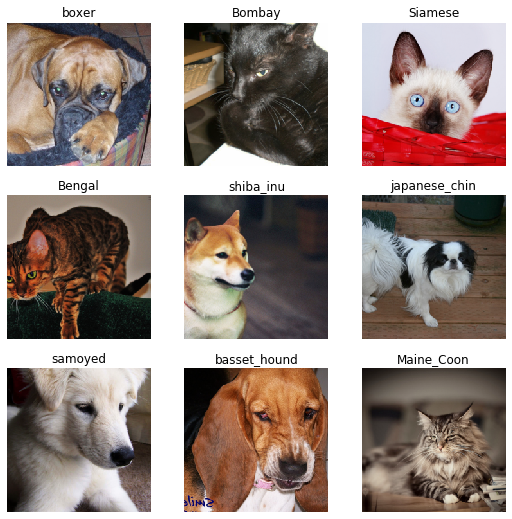

In [10]:
dls.show_batch()

In [12]:
#learn.lr_find()

In [ ]:
learn.fine_tune(5)

/home/bf/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/jit/__init__.py:1119: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 3 element(s) (out of 592) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 1.4781951904296875e-05 (-0.20771926641464233 vs. -0.20773404836654663), which occurred at index (10, 32).
  check_tolerance, strict, _force_outplace, True, _module_class)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.372129,1.809393,0.253721,0.746279,02:00


/home/bf/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/jit/__init__.py:1119: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1 element(s) (out of 592) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 1.0967254638671875e-05 (-0.08141958713531494 vs. -0.08143055438995361), which occurred at index (11, 26).
  check_tolerance, strict, _force_outplace, True, _module_class)


epoch,train_loss,valid_loss,error_rate,accuracy,time


In [ ]:
learn.recorder.plot_sched()

In [20]:
import timm
#timm.list_models()[:10]
timm.list_models('*efficientnet*')[:10]

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4']